# Process 202405-2xrez Bathymetry

Based on `tools/bathymetry/Process202108Bathymetry.ipynb` notebook.

Base bathymetry was created in the
https://github.com/SalishSeaCast/analysis-doug/blob/main/notebooks/2xrez-202111/bathymetry-202405-2xrez.ipynb
notebook by following Michael's process.
Its major differences from the double resolution 202207j bathymetry are:
* Changed the Pitt River to be a short, closed stub
* Changed the proxy Fraser River extension to go southward instead of northward,
  and to start just east of the mouth of the Pitt River instead of from the Pitt

Processing steps:
1. Straighten Channel at North Open Boundary
2. Straighten Channel at West Open Boundary
3. Check continuity and Add Missed Islands
    1. Fix Puget Sound
4. Smooth
    1. Extra smooth Puget Sounnd
5. Add shallow Steeveston Jetty
6. Check dredged Fraser River Channel
7. Check continuity and fix islands:
    1. connect Roche Harbour
    2. remove extra little island on mudflats
    3. don't close north of Read Island
    4. Disconnect Stuart Island
    5. Deepen Tacoma Narrows
8. Plot up our Final Bathymetry
9. Write out bathy file and jetty extra friction files


In [1]:
from pathlib import Path
import sys

import cmocean.cm as cm
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np

from salishsea_tools import bathy_tools, nc_tools, viz_tools

import matplotlib.colors as matcolors
import matplotlib.cm as cmx

Python and library versions:

In [2]:
import bottleneck
import cmocean
import h5netcdf
import h5py
import matplotlib
import netCDF4
import numpy
import pandas
import scipy
import xarray

print(f"Python {sys.version=}")
print(f"{numpy.__version__=}")
print(f"{xarray.__version__=}")
print(f"{bottleneck.__version__=}")
print(f"{pandas.__version__=}")
print(f"{h5netcdf.__version__=}")
print(f"{h5py.__version__=}")
print(f"{netCDF4.__version__=}")
print(f"{scipy.__version__=}")
print(f"{matplotlib.__version__=}")
print(f"{cmocean.__version__=}")

Python sys.version='3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC 12.3.0]'
numpy.__version__='1.26.4'
xarray.__version__='2024.6.0'
bottleneck.__version__='1.4.0'
pandas.__version__='2.2.2'
h5netcdf.__version__='1.3.0'
h5py.__version__='3.11.0'
netCDF4.__version__='1.6.5'
scipy.__version__='1.14.0'
matplotlib.__version__='3.8.4'
cmocean.__version__='v3.0.3'


## Load, Plot and `depth_check()` the Bathymetry

In [3]:
# isolate the probable user-specific part of repo paths to make the notebook portable
repos_prefix = Path("/media/doug/warehouse/MEOPAR/")

In [4]:
bathy_paths = {
    "dbl_202405": repos_prefix / "grid" / "bathymetry_double_202405_base.nc",
    "dbl_final_202405": repos_prefix / "grid" / "bathymetry_double_202405.nc.nc",
}

In [5]:
with xarray.open_dataset(bathy_paths["dbl_202405"], engine="h5netcdf") as bathy:
    lons = bathy.nav_lon
    lats = bathy.nav_lat
    base_bathy = bathy.Bathymetry

Calculate expanded `lons` and `lats` arrays by extrapolating values on south and east edges.
This provides arrays that `pcoulormesh()` interprets as cell edges so that it doesn't a
`UserWarning` about the non-montonic lon/lat values that arise due to the rotated grid.
This code is based on Michael's `expandf()` function in
https://github.com/SalishSeaCast/analysis-michael/blob/master/bathymetry/bathy_helpers.py

In [6]:
lons_e = numpy.zeros((lons.shape[0]+1, lons.shape[1]+1))
lons_e[1:, 1:] = lons
lons_e[0, 1:] = lons[0, :] - (lons[1, :] - lons[0, :])
lons_e[:, 0] = lons_e[:, 1] - (lons_e[:, 2] - lons_e[:, 1])

lats_e = numpy.zeros((lats.shape[0]+1, lats.shape[1]+1))
lats_e[1:, 1:] = lats
lats_e[0, 1:] = lats[0, :] - (lats[1, :] - lats[0, :])
lats_e[:, 0] = lats_e[:, 1] - (lats_e[:, 2] - lats_e[:, 1])

Plotting setup:

In [7]:
cmap = cm.deep
cmap.set_bad('darkgreen')
lon_limits = (47, 51)
lat_limits = (-126.3, -122.2)
y_max = base_bathy.y.max().item() + 1
x_max = base_bathy.x.max().item() + 1
cNorm  = matcolors.Normalize(vmin=0, vmax=14)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap='cool')

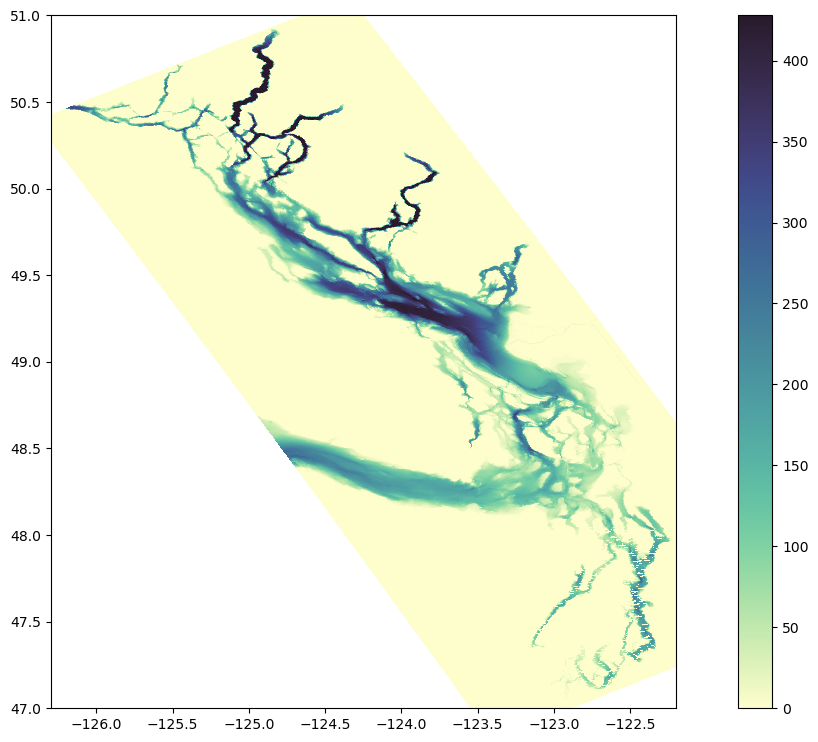

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ax.set_ylim(lon_limits)
ax.set_xlim(lat_limits)
viz_tools.set_aspect(ax, coords='map')
mesh = ax.pcolormesh(lons_e, lats_e, base_bathy, cmap=cmap)
fig.colorbar(mesh, ax=ax);

In [9]:
def depth_check(bathy):
    """Checks the depth at each point of the bathymetric data and prints
    whether it is "Deep" or "Shallow".

    A depth greater than 428 is considered "Deep" and a depth between 0
    and 4 (non-inclusive) is considered "Shallow". The function iterates
    through the entire 2D array of bathymetric data to classify each point.

    :param bathy: 2D array of bathymetric data where each element represents
                  the depth at that point
    :type bathy: numpy.ndarray

    :return: None
    """
    DEEP_DEPTH_THRESHOLD = 428
    SHALLOW_DEPTH_UPPER_THRESHOLD = 4
    SHALLOW_DEPTH_LOWER_THRESHOLD = 0

    # Utility function to encapsulate repeating depth info printing
    def print_depth_info(mask, label, base_bathy):
        for y in mask.y:
            for x in mask.x:
                if mask[y, x]:
                    print(
                        f"{label}: y={y.item()}, x={x.item()}, depth={base_bathy[y, x].item()}"
                    )

    # Identify deep and shallow areas
    deep_mask = bathy > DEEP_DEPTH_THRESHOLD
    shallow_mask = numpy.logical_and(
        base_bathy < SHALLOW_DEPTH_UPPER_THRESHOLD,
        base_bathy > SHALLOW_DEPTH_LOWER_THRESHOLD
    )

    # Handle deep areas
    if deep_mask.any():
        print_depth_info(deep_mask, "Deep", base_bathy)

    # Handle shallow areas
    if shallow_mask.any():
        print_depth_info(shallow_mask, "Shallow", base_bathy)


In [10]:
depth_check(base_bathy)

## Straighten Channel at North Open Boundary

Change the shape of Johnstone Strait at the north boundary of the grid to make it perpendicular to the grid edge.
This is done to avoid numerical instabilities.

In [11]:
ns_bathy = base_bathy.copy()
js = 37*2  # x index to start changes at
je = 75*2  # x index to end changes at

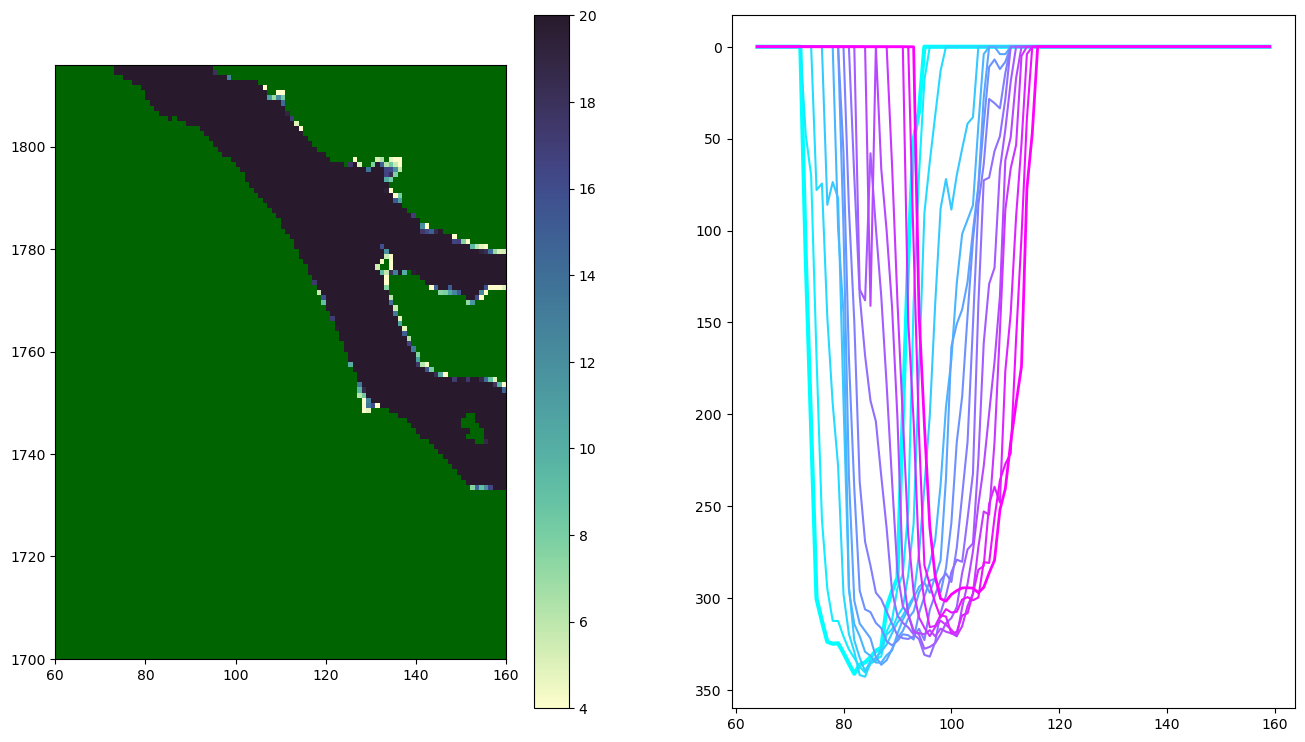

In [12]:
ns_masked = np.ma.masked_array(ns_bathy, ns_bathy == 0)


def plot_north_bdy(ns_masked, y_max):
    fig, (ax_plan, ax_depth) = plt.subplots(1, 2, figsize=(16, 9))
    ax_plan.set_ylim((850*2, y_max))
    ax_plan.set_xlim((30*2, 80*2))
    viz_tools.set_aspect(ax_plan)
    mesh = ax_plan.pcolormesh(ns_masked, cmap=cmap, vmax=20)
    fig.colorbar(mesh, ax=ax_plan)
    ax_depth.plot(range(js - 10, je + 10), ns_bathy[y_max - 1, js - 10:je + 10],
                  color=scalarMap.to_rgba(0), linewidth=3)
    for i in range(1, 14):
        ax_depth.plot(range(js - 10, je + 10), ns_bathy[y_max - 1 - i, js - 10:je + 10],
                      color=scalarMap.to_rgba(i))
    ax_depth.plot(range(js - 10, je + 10), ns_bathy[y_max - 1 - 14, js - 10:je + 10],
                  color=scalarMap.to_rgba(14), linewidth=2)
    ax_depth.invert_yaxis()


plot_north_bdy(ns_masked, y_max)

In [17]:
init_north = np.array(base_bathy[y_max-1, :])
# shift north bathymetry 7 points west
north = np.zeros_like(init_north)
north[js:je] = init_north[js-7:je-7]

#first 6 grid points (0-5) use the same, core profile shifted east.  After that merge into the original
#bathymetry, shifting South by half a grid point per grid point east.

# Closest 5 rows to northern boundary, all the same as the boundary
for i in range(y_max-5, y_max):
    ns_bathy[i, js:je] = north[js:je]
# Now move away from the boundary, blending

i=5; ii=y_max-1-i
ns_bathy[ii, js:je] = (-i+15)/10.*north[js:je] + (i-5)/10.*ns_bathy[ii, js:je]
i=6; ii=y_max-1-i
ns_bathy[ii, js:je] = (-i+15)/10.*north[js-1:je-1] + (i-5)/10.*ns_bathy[ii, js:je]
i=7; ii=y_max-1-i
ns_bathy[ii, js:je] = (-i+15)/10.*north[js-2:je-2] + (i-5)/10.*ns_bathy[ii, js:je]
i=8; ii=y_max-1-i
ns_bathy[ii, js:je] = (-i+15)/10.*north[js-3:je-3] + (i-5)/10.*ns_bathy[ii, js:je]
i=9; ii=y_max-1-i
ns_bathy[ii, js:je] = (-i+15)/10.*north[js-4:je-4] + (i-5)/10.*ns_bathy[ii, js:je]
i=10; ii=y_max-1-i
ns_bathy[ii, js:je] = (-i+15)/10.*north[js-5:je-5] + (i-5)/10.*ns_bathy[ii, js:je]
i=11; ii=y_max-1-i
ns_bathy[ii, js:je] = (-i+15)/10.*north[js-6:je-6] + (i-5)/10.*ns_bathy[ii, js:je]
i=12; ii=y_max-1-i
ns_bathy[ii, js:je] = (-i+15)/10.*north[js-7:je-7] + (i-5)/10.*ns_bathy[ii, js:je]
i=13; ii=y_max-1-i
ns_bathy[ii, js:je] = (-i+15)/10.*north[js-8:je-8] + (i-5)/10.*ns_bathy[ii, js:je]
i=14; ii=y_max-1-i
ns_bathy[ii, js:je] = (-i+15)/10.*north[js-9:je-9] + (i-5)/10.*ns_bathy[ii, js:je]

In [18]:
# Remove shallow points, deepen points almost at 4
for i in range(880*2,y_max):
    for j in range(30*2, 80*2) :
        if ns_bathy[i, j] < 2:
            ns_bathy[i, j] = 0
        elif ns_bathy[i, j] < 4:
            ns_bathy[i, j] = 4

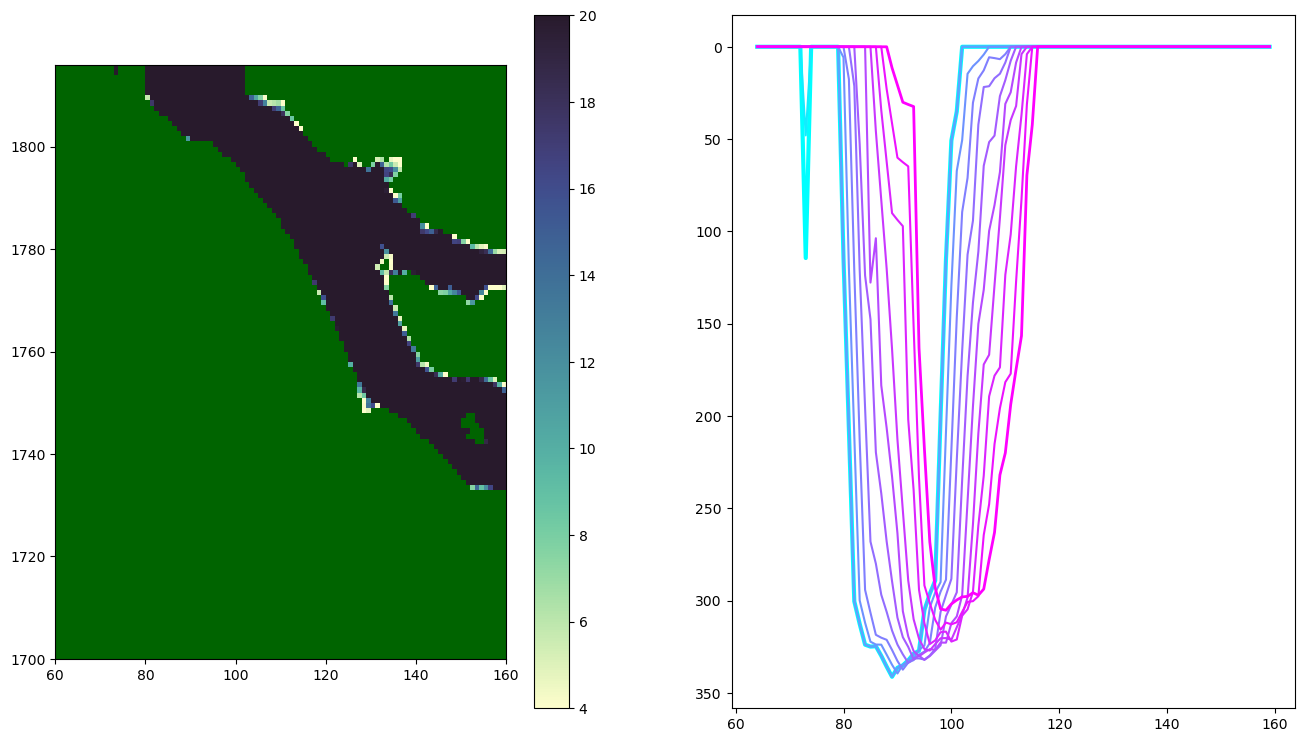

In [19]:
ns_masked = np.ma.masked_array(ns_bathy, ns_bathy == 0)
plot_north_bdy(ns_masked, y_max)

depth_check(ns_masked)